## Accessing Sentinel-3 data on Azure

The [Sentinel-3](https://sentinel.esa.int/web/sentinel/missions/sentinel-3) mission provides global multispectral imagery at a resolution of 300m-500m, with a revisit time of approximately two days, from 2016 to the present, in NetCDF format.

This notebook demonstrates access to Sentinel-3 data on Azure, using sentinelsat to query the Copernicus Open Access Hub for scenes, then accessing the scenes on Azure blob storage.  Because Sentinel-3 data are in preview on Azure, the user needs to provide storage credentials.  To access the Copernicus Open Access Hub for spatiotemporal search, the user also needs to provide Open Access Hub credentials.  This data will soon be available via the [Planetary Computer API](https://planetarycomputer.microsoft.com), which will eliminate the need for manually providing credentials.

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented at [aka.ms/ai4edata-sentinel-3](http://aka.ms/ai4edata-sentinel-3).

Sentinel-3 data on Azure are maintained by [Sinergise](https://sinergise.com/).

### Imports

In [1]:
import os
import datetime
import fsspec
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from azure.storage.blob import ContainerClient
from sentinelsat import SentinelAPI

# Not used directly, but needs to be installed to read NetCDF files with xarray
import h5netcdf

### Constants

In [2]:
# This can be either a SAS token or a file with a SAS token on the first line
sas_token = os.path.expanduser('~/tokens/sentinel-3_sas.txt')

# A text file with a login on the first line, password on the second line
copernicus_credentials_file = os.path.expanduser('~/tokens/coah_username_password.txt')

# Or specify username/password
username = None; password = None

api_url = 'https://scihub.copernicus.eu/dhus'
platform_name = 'Sentinel-3'

# Keys are valid product types for the Open Access Hub follow; others are available via 
# the marine hub.  Values are the top-level folders in which these products are stored
# on Azure.

valid_coah_product_types = {
 'OL_1_EFR___':None,
 'OL_1_ERR___':None,
 'OL_2_LFR___':'OLCI',
 'OL_2_LRR___':'OLCI',
 'SL_1_RBT___':None,
 'SL_2_LST___':'SLSTR',
 'SR_1_SRA_A_':None,
 'SR_1_SRA_BS':None,
 'SR_1_SRA___':None,
 'SR_2_LAN___':'SRAL',
 'SY_2_SYN___':'SYNERGY',
 'SY_2_V10___':'SYNERGY',
 'SY_2_VG1___':'SYNERGY',
 'SY_2_VGP___':'SYNERGY'
 }

# Select channels for our RGB composite
#
# We'll use just OLCI data from the level-2 reflectance data:
#
# https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/olci/    
channels = ['Oa07','Oa06','Oa04']

# A decent composite of SLSTR data from the level-2 reflectance data
# channels = ['S1N','S2N','S3N']

# This is the product type for the synergy (OLCI + SLSTR) surface reflectance product
product_type = 'SY_2_SYN___'

assert product_type in valid_coah_product_types.keys()

# Downscaling factor for plotting
dsfactor = 5

### Query parameters

In [3]:
start_time = datetime.datetime(2019,6,1,0,0,0)
end_time = datetime.datetime(2019,8,1,0,0,0)
max_cloud_cover_percent = 50

# Around the Grand canyon
lat =  36.101690; lon = -112.107676; brightness = 2

# Around Jonah Bay, Alaska
# lat = 61.00212860030653; lon = -147.7789234838648; brightness = 10

# Redmond, WA, USA
# lat = 47.54687159892238; lon = -122.27508544921875; brightness = 10

# Format point as WKT
footprint = 'POINT({:.4f} {:.4f})'.format(lon,lat)

### Create Sentinel-3 container client

In [4]:
# SAS token can be specified directly, or specified as a file with a SAS token on the first line
if not sas_token.startswith('?'):
        lines = []
        with open(sas_token,'r') as f:
            lines = f.readlines()
        assert len(lines) >= 1
        sas_token = lines[0].strip()
    
storage_account_name = 'sentinel3euwest'
container_name = 'sentinel-3'

storage_account_url = 'https://' + storage_account_name + '.blob.core.windows.net/'

container_client = ContainerClient(account_url=storage_account_url, 
                                             container_name=container_name,
                                             credential=sas_token)

api = SentinelAPI(user=username, password=password, api_url=api_url)

### Connect to the Open Access Hub API

In [5]:
if copernicus_credentials_file is not None:

    assert username is None 
    assert password is None    

    lines = []
    with open(copernicus_credentials_file,'r') as f:
        lines = f.readlines()
    assert len(lines) >= 2
    
    username = lines[0].strip()
    password = lines[1].strip()
        
api = SentinelAPI(user=username, password=password, api_url=api_url)

### Query for scenes

In [6]:
products = api.query(footprint,
                     date=(start_time,end_time),
                     platformname=platform_name,
                     producttype=product_type,
                     cloudcoverpercentage=(0, max_cloud_cover_percent))

product_values = list(products.values())
    
print('Found {} scenes'.format(len(products)))

# Choose the least cloudy scene
product = sorted(product_values, key=lambda item: item['cloudcoverpercentage'])[0]

print('Using least cloudy scene: {} ({})'.format(product['title'],product['cloudcoverpercentage']))

Found 72 scenes
Using least cloudy scene: S3B_SY_2_SYN____20190709T172018_20190709T172318_20190711T043412_0179_027_226_2340_LN2_O_NT_002 (1.975952)


### Formulate a Sentinel-3 path in our container's format

In [7]:
# For the product:
#
# S3B_SY_2_SYN____20190618T211806_20190618T212106_20190620T050408_0179_026_314_1800_LN2_O_NT_002.SEN3
#    
# Our path is:
#    
# https://sentinel3euwest.blob.core.windows.net/sentinel-3
#
# /SYNERGY/SY_2_SYN___/2019/06/18/S3B_SY_2_SYN____20190618T211806_20190618T212106_20190620T050408_0179_026_314_1800_LN2_O_NT_002.SEN3/
#

# E.g.:
#    
# S3B_SY_2_SYN____20190618T211806_20190618T212106_20190620T050408_0179_026_314_1800_LN2_O_NT_002.SEN3    
original_filename = product['filename']

assert(product_type == original_filename[4:15])

scene_year = original_filename[16:20]
scene_month = original_filename[20:22]
scene_day = original_filename[22:24]

top_level_folder = valid_coah_product_types[product_type]

azure_scene_prefix = '/'.join([top_level_folder,product_type,scene_year,scene_month,scene_day,original_filename])

print('Azure scene prefix: {}'.format(azure_scene_prefix))

Azure scene prefix: SYNERGY/SY_2_SYN___/2019/07/09/S3B_SY_2_SYN____20190709T172018_20190709T172318_20190711T043412_0179_027_226_2340_LN2_O_NT_002.SEN3


### Select the three files we want for RGB rendering

In [8]:
generator = container_client.list_blobs(name_starts_with=azure_scene_prefix)
image_blobs = [blob.name for blob in generator if blob.name.endswith('.nc')]

print('Found {} image files'.format(len(image_blobs)))
# for s in image_blobs:
#     print(s)

rgb_blobs = []
for c in channels:
    for blob_path in image_blobs:
        if c in blob_path:
            rgb_blobs.append(blob_path)
            break
        
print('Using the following for our RGB composite:')
        
assert(len(rgb_blobs) == 3)
for blob_path in rgb_blobs:
    print(blob_path.split('/')[-1])

Found 38 image files
Using the following for our RGB composite:
Syn_Oa07_reflectance.nc
Syn_Oa06_reflectance.nc
Syn_Oa04_reflectance.nc


### Convert to Azure URLs

In [9]:
rgb_urls = []
for blob_path in rgb_blobs:
    rgb_urls.append(storage_account_url + container_name + '/' + blob_path + sas_token)

### Read data

In [10]:
channel_data = []

# i_url = 0; url = rgb_urls[i_url]
for i_url,url in enumerate(rgb_urls):
    
    channel_name = channels[i_url]
    with fsspec.open(url) as f:
        ds = xr.open_dataset(f)
        
        # Find the variable matching our channel name... e.g. for Oa04, there 
        # will be a variable called SDR_Oa04.
        variables = list(ds.variables)
        variable_name = None
        for s in variables:
            if channel_name in s and 'err' not in s:
                variable_name = s
                break
        assert variable_name is not None
        
        print('Reading variable {} from {}'.format(variable_name,url.split('?')[0].split('/')[-1]))
        
        # This initiates a read of a 2D image, and downsamples the result
        variable_value = ds[variable_name].coarsen(rows=dsfactor,columns=dsfactor,boundary='trim').mean()
        
        # You can plot this channel directly with xarray's built-in plotting functionality
        # variable_value.plot()
        
        # This initiates the read
        v = variable_value.values
        assert len(v.shape) == 2
        channel_data.append(v)

    # ...with fsspec.open()
    
# ...for each band

Reading variable SDR_Oa07 from Syn_Oa07_reflectance.nc
Reading variable SDR_Oa06 from Syn_Oa06_reflectance.nc
Reading variable SDR_Oa04 from Syn_Oa04_reflectance.nc


### Plot our RGB composite

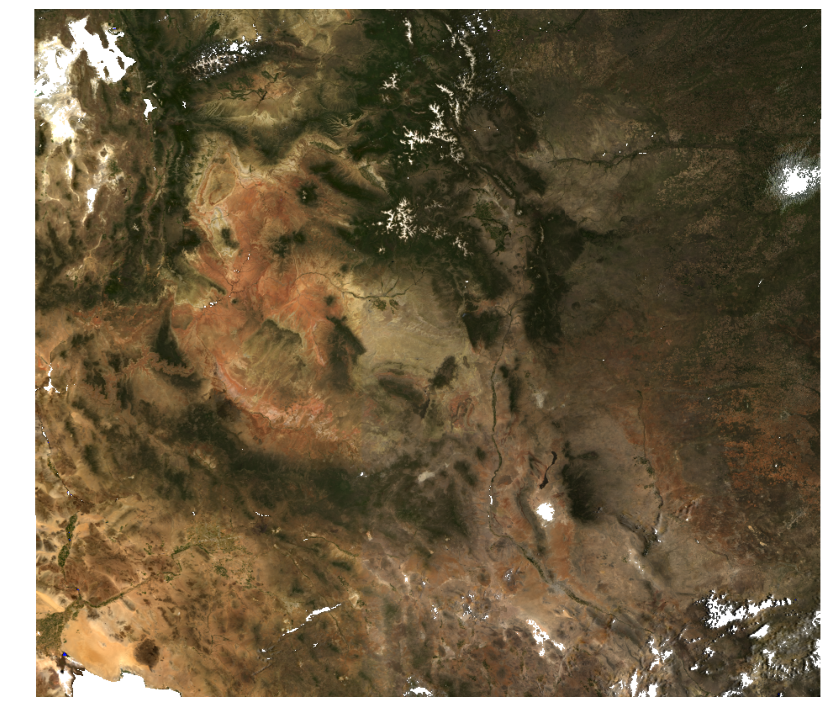

In [11]:
def scale_channel(x):
    # return np.nan_to_num(x*brightness)
    y = x*brightness
    
    # Convert NaN to 1.0, because it looks a little nicer to plot over a white
    # background
    y[np.isnan(y)] = 1.0
    np.clip(y,0,1,y)
    return y

rgb = np.dstack([scale_channel(channel_data[0]),
                 scale_channel(channel_data[1]),
                 scale_channel(channel_data[2])])

w = channel_data[0].shape[0]; h = channel_data[0].shape[1]
dpi = 100; fig = plt.figure(frameon=False,figsize=(w/dpi,h/dpi),dpi=dpi)
ax = plt.Axes(fig,[0., 0., 1., 1.]); ax.set_axis_off(); fig.add_axes(ax)

plt.imshow(rgb);